In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Colab auth
from google.colab import auth
from google.cloud import storage

# Helper Functions

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def get_folder_size(base_path):
  folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  return folder_size

# Get Dataset size
def get_dataset_size(base_path):
  dataset_folder_size = get_folder_size(base_path)
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size (Zip + Extracted): ",dataset_folder_size)
  size_type = ""
  if dataset_folder_size.endswith("M"):
    size_type = "MB"
    dataset_folder_size = dataset_folder_size.replace("M","000000")
  elif dataset_folder_size.endswith("G"):
    size_type = "GB"
    dataset_folder_size = dataset_folder_size.replace("G","000000000")

  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_size = dataset_folder_size - dataset_download_size

  if size_type == "MB":
    dataset_download_size = dataset_download_size/1000000
    dataset_size = dataset_size/1000000
  elif size_type == "GB":
    dataset_download_size = dataset_download_size/1000000000
    dataset_size = dataset_size/1000000000

  print("Download Size (Zip): ",str(round(dataset_download_size,4))+size_type)
  print("Dataset Size (Extracted): ",str(round(dataset_size,4))+size_type)

def compute_dataset_metrics(dataset_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def display_memory_usage(variables, top_n=10):
  variables_size = [(name, sys.getsizeof(value)) for name, value in variables]
  total_size = sum([itm[1] for itm in variables_size])
  # top n
  variables_size = sorted((variables_size),key= lambda x: -x[1])[:top_n]

  for name, size in variables_size:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

  # Total
  print("{:>30}{:>8}".format("------------", "------------"))
  print("{:>30}: {:>8}".format("Total:", sizeof_fmt(total_size)))

def evaluate_model(model,test_data, training_results):

  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  if type(test_data) is tuple:
    evaluation_results = model.evaluate(test_data[0],test_data[1])
  else:
    evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

## Download images from GCP

In [ ]:
# This step is required for DVC in colab to access your Bucket
auth.authenticate_user()

In [ ]:
def makedirs():
    os.makedirs(input_images, exist_ok=True)
    os.makedirs(output_images, exist_ok=True)


In [ ]:
def download():
    print("downloading")

    # Clear
    #shutil.rmtree(input_images, ignore_errors=True, onerror=None)
    #makedirs()

    client = storage.Client.from_service_account_json(secrets_json)
    bucket = client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=gcs_input_folder + "/")
    count = 0
    for blob in blobs:
        count += 1
        if count % 1000 == 0 :
            print(count)
        if not blob.name.endswith("/"):
            filename = str(blob.name)
            filename = filename.replace(gcs_input_folder, gcs_input_folder[:3])
            filename = filename.replace("/","")
            filename = filename.replace("image","")
            filename = input_images + "/" + filename
            blob.download_to_filename(filename)

    print(count)
    print("finished downloading")

In [ ]:
def resize():
    print("resize")
    makedirs()

    # Get the list of image files
    image_files = os.listdir(input_images)


    # resize
    s = args.size
    for image_file in image_files:
        img = Image.open(input_images + '/' + image_file)
        resized_img = img.resize((s,s))
        resized_img.save('output_images/' + image_file, 'JPEG')

In [ ]:
secrets_json = '/content/secrets/gcp-rehab-ai-secret.json'
bucket_name = "rehab-image-detection-data"
input_images = "input_images"
output_images = "output_images"


In [ ]:
# downloading raw fixer-upper images
# create a directory called 'input_images'
input_images = "input_images"

# specify which folder
gcs_input_folder = 'fixer-upper'
download()

downloading
1000
2000
3000
4000
5000
6000
7000
8000
8717
finished downloading


In [ ]:
# Folder size with only raw fixer-upper images
get_folder_size('/content/input_images')

'286M'

In [ ]:
# download raw renovated images to
gcs_input_folder = 'renovated'
download()

downloading
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
13785
finished downloading


In [ ]:
# Folder size with raw fixer-upper and renovated images
get_folder_size('/content/input_images')

'726M'

## Create list of image labels and image filepaths, Train/Test Split

In [ ]:
# check filenames are all jpg
input_path = '/content/input_images'

filenames = os.listdir(input_path)
for filename in filenames:
  if filename[-3:] != 'jpg':
    print(filename)
    filenames.remove(filename)

ren.DS_Store


In [ ]:
# recheck filenames
for filename in filenames:
  if filename[-3:] != 'jpg':
    print(filename)
    filenames.remove(filename)

In [ ]:
# Create list with tuples of label and filepath: [(label, filepath)]

input_path = '/content/input_images'

# Get clean filenames list from above
filenames = filenames

# Create list, with labels ren=0 and fix=1
# Double check fix and ren pic counts
data_list = []
ren_count = 0
fix_count = 0

for filename in filenames:
  filepath = os.path.join(input_path, filename)

  if filename[0:3] == 'ren':
    ren_count += 1
    tup = (0, filepath)
    data_list.append(tup)

  if filename[0:3] == 'fix':
    fix_count += 1
    tup = (1, filepath)
    data_list.append(tup)

print("renovated pics:", ren_count)
print("fixer-upper pics:", fix_count)
print(data_list[0:5])
print(data_list[-5:])

renovated pics: 13783
fixer-upper pics: 8716
[(0, '/content/input_images/ren7657683522_14.jpg'), (1, '/content/input_images/fix7668387943_20.jpg'), (1, '/content/input_images/fix7670415488_15.jpg'), (1, '/content/input_images/fix7660562533_18.jpg'), (0, '/content/input_images/ren7662672098_5.jpg')]
[(0, '/content/input_images/ren7666383320_12.jpg'), (1, '/content/input_images/fix7670912850_5.jpg'), (0, '/content/input_images/ren7672285484_11.jpg'), (1, '/content/input_images/fix7670758896_6.jpg'), (0, '/content/input_images/ren7662451762_12.jpg')]


In [ ]:
# Set random seed
random_state = 1

# Create Train and Test Set
test_percent = 0.2

# Split data into train / validate
train_xy, test_xy = train_test_split(data_list, test_size=test_percent, random_state = random_state)

print("train_xy count:",len(train_xy))
print("test_xy count:",len(test_xy))

train_xy count: 17999
test_xy count: 4500


In [ ]:
# Train and Test Set
# Check class split
fix_class_count = 0
for tup in train_xy:
  fix_class_count = fix_class_count + tup[0]

print('Train set, Fixer-upper %:', round(fix_class_count/len(train_xy), 4))

fix_class_count = 0
for tup in test_xy:
  fix_class_count = fix_class_count + tup[0]

print('Test set, Fixer-upper %:', round(fix_class_count/len(test_xy), 4))


Train set, Fixer-upper %: 0.3891
Test set, Fixer-upper %: 0.3804


In [ ]:
# Create Train and Validation Set
val_percent = 0.2

# Split data into train / validate
train_xy_2, val_xy = train_test_split(train_xy, test_size=val_percent, random_state = random_state)

print("train_xy_2 count:",len(train_xy_2))
print("val_xy count:",len(val_xy))

train_xy_2 count: 14399
val_xy count: 3600


In [ ]:
# Train and Val Set
# Check class split
fix_class_count = 0
for tup in train_xy_2:
  fix_class_count = fix_class_count + tup[0]

print('Train set, Fixer-upper %:', round(fix_class_count/len(train_xy_2), 4))

fix_class_count = 0
for tup in val_xy:
  fix_class_count = fix_class_count + tup[0]

print('Val set, Fixer-upper %:', round(fix_class_count/len(val_xy), 4))


Train set, Fixer-upper %: 0.3875
Val set, Fixer-upper %: 0.3958


## Create TF Record

In [ ]:
# Define Function
def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  # label = label2index[item[0]]
  label = item[0]

  # Build feature dict
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example



In [ ]:
# Define Function

output_path = '/content/tfrecords'

def create_tf_records(data,num_shards=10, prefix='', folder=output_path):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString())

In [ ]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "tf-records"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)


In [ ]:
# Create train_xy_2 TFRecords
# 5 shards because 0.64 x 726MB = 464.64MB
num_shards = 5
prefix = 'train'
data = train_xy_2
output_folder = '/content/tf-records'

create_tf_records(data, num_shards=num_shards, prefix=prefix, folder=output_folder)

Creating shard: 0  from records: 0 to 2880
/content/tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 2880 to 5760
/content/tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 5760 to 8640
/content/tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 8640 to 11520
/content/tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 11520 to 14400
/content/tfrecords/train_0004.tfrecords


In [ ]:
# Create test_xy TFRecords
# 2 shards because 0.2 x 726MB = 145.2MB
num_shards = 1
prefix = 'test'
data = test_xy
output_folder = '/content/tf-records'

create_tf_records(data, num_shards=num_shards, prefix=prefix, folder=output_folder)

Creating shard: 0  from records: 0 to 2251
/content/tfrecords/test_0000.tfrecords
Creating shard: 1  from records: 2251 to 4502
/content/tfrecords/test_0001.tfrecords


In [ ]:
# Create val_xy TFRecords
# 2 shards because 0.16 x 726MB = 116.16MB
num_shards = 1
prefix = 'val'
data = val_xy
output_folder = '/content/tf-records'

create_tf_records(data, num_shards=num_shards, prefix=prefix, folder=output_folder)

Creating shard: 0  from records: 0 to 1801
/content/tfrecords/val_0000.tfrecords
Creating shard: 1  from records: 1801 to 3602
/content/tfrecords/val_0001.tfrecords


In [ ]:
print("TFRecord folder size:", get_folder_size(output_folder))

TFRecord folder size: 3.2G


## Load TF Data from TFRecords

In [ ]:
# Load TF Data from TFRecords
batch_size = 128
num_classes = 2

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])

  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

In [ ]:
# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

In [ ]:
# Create TF Dataset
tfrecords_dir = '/content/tf-records'
dataset_prefix = 'test'

sample_dataset = tf.data.Dataset.list_files(tfrecords_dir + '/' + dataset_prefix + '*')
sample_dataset = sample_dataset.flat_map(tf.data.TFRecordDataset)
sample_dataset = sample_dataset.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
sample_dataset = sample_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
sample_dataset = sample_dataset.batch(batch_size)
sample_dataset = sample_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
print(sample_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 2)
[1. 0.]


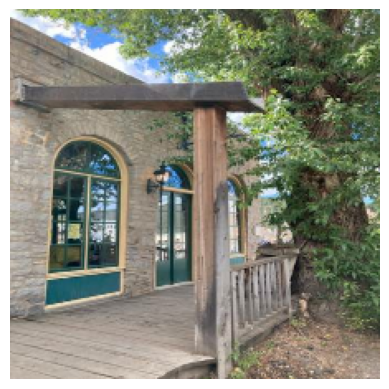

In [ ]:
# View data from TFRecord
for batch in sample_dataset.take(1):
  image, label = batch

  print(type(image), image.shape)
  print(type(label),label.shape)

  # Convert image to numpy
  image = image.numpy()[0]
  label = label.numpy()[0]

  print(label)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Upload TFRecords to GCP

In [ ]:
def upload():
    print("upload")

    # Upload to bucket
    client = storage.Client.from_service_account_json(secrets_json)
    bucket = client.bucket(bucket_name)

    # Get the list of filenames from local dir
    filenames = os.listdir(local_dir)

    count = 0
    for filename in filenames:
        count += 1

        # Create GCP destination path and blob object
        destination_path = os.path.join(gcp_dir, filename)
        blob = bucket.blob(destination_path)

        # Get filepath to upload
        filepath = os.path.join(local_dir, filename)

        # Upload filepath to GCP
        blob.upload_from_filename(filepath)

    # Clear
    print('Finished Uploading')
    #shutil.rmtree(output_images, ignore_errors=True, onerror=None)
    #makedirs()

In [ ]:
gcp_dir = 'tf-records'
local_dir = '/content/tfrecords'
secrets_json = '/content/secrets/gcp-rehab-ai-secret.json'
bucket_name = "rehab-image-detection-data"

upload()

upload
Finished Uploading
